In [124]:
import torch
from src.constants import *
from src.gan_models import *
import time
import matplotlib.pyplot as plt

In [125]:
device = 'cpu'
# Check if MPS is supported and available
if torch.backends.mps.is_available():
    print("MPS is available on this device.")
    device = torch.device("mps")  # Use MPS device
else:
    print("MPS not available, using CPU instead.")
    device = torch.device("cpu")  # Fallback to CPU



MPS is available on this device.


# Load model

In [126]:
model_path = 'models/generator_model_artist_201.pt'

g_model = DCGANGeneratorNet()  # Ensure the class is defined or imported
g_model.load_state_dict(torch.load(model_path))
g_model.to(device)
g_model.eval()  # Set to evaluation mode if not training further

DCGANGeneratorNet(
  (cons_layers): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(128, 1, 1))
    (1): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ConvTranspose2d(128, 64, kernel_

In [149]:
n_sample_points = 60

def create_trajectory(start, end, n_samples, device):
    direction = end - start
    trajectory = [start + (i * direction) / (n_samples + 1) for i in range(n_samples + 2)] 
    
    return trajectory 

def get_orthogonal_point(point):
    orthogonal = torch.linalg.svd(point)
    print(orthogonal.Vh)
    
def find_farest_point(point):
    max_attempt = 100
    test_point = torch.randn(1, LATENT_DIM).to(device)
    farest_point = test_point
    max_dist = 0
    for i in range(max_attempt):
        test_point = torch.randn(1, LATENT_DIM).to(device) 
        dist = torch.linalg.norm(point - test_point)
        if dist > max_dist:
            max_dist = dist
            farest_point = test_point
    
    print(f'Distance: {torch.linalg.norm(point - farest_point)}')
    return farest_point
    

start_point = torch.randn(1, LATENT_DIM).to(device)
# end_point = torch.randn(1, LATENT_DIM).to(device)
end_point = find_farest_point(start_point)
# end_point = get_orthogonal_point(start_point) 
# start_point = torch.full((1, LATENT_DIM), -1, device=device)
# end_point = torch.full((1, LATENT_DIM), 1, device=device)

trajectory = create_trajectory(start_point, end_point, n_sample_points, device)

tr2 = create_trajectory(end_point, find_farest_point(end_point), n_sample_points, device)

trajectory = trajectory + tr2

print(f'Total Trajectory: {len(trajectory)}')

generated_images = []
cost_times = []

for idx, inter_point in enumerate(trajectory):
    start_ts = time.time()
    output = g_model(inter_point)
    img = output[0, :, :, :].detach().cpu().permute(1, 2, 0).numpy()
    normalized_img = (img + 1) / 2
    generated_images.append(normalized_img) 
    cost_ts = (time.time() - start_ts) * 1000
    cost_times.append(cost_ts) 
    print(f'[{idx}]Image generated in {cost_ts} ms')

print(f'Generated images: {len(generated_images)}')



Distance: 17.96612548828125
Distance: 19.21708106994629
Total Trajectory: 124
[0]Image generated in 265.41900634765625 ms
[1]Image generated in 7.903814315795898 ms
[2]Image generated in 7.786989212036133 ms
[3]Image generated in 5.6610107421875 ms
[4]Image generated in 6.7958831787109375 ms
[5]Image generated in 5.581140518188477 ms
[6]Image generated in 6.583690643310547 ms
[7]Image generated in 5.69605827331543 ms
[8]Image generated in 5.17725944519043 ms
[9]Image generated in 5.893945693969727 ms
[10]Image generated in 7.341146469116211 ms
[11]Image generated in 6.719112396240234 ms
[12]Image generated in 4.873991012573242 ms
[13]Image generated in 5.624055862426758 ms
[14]Image generated in 4.955768585205078 ms
[15]Image generated in 5.993127822875977 ms
[16]Image generated in 7.104635238647461 ms
[17]Image generated in 8.28695297241211 ms
[18]Image generated in 7.533073425292969 ms
[19]Image generated in 6.887197494506836 ms
[20]Image generated in 6.503820419311523 ms
[21]Image g

Text(0, 0.5, 'Time (ms)')

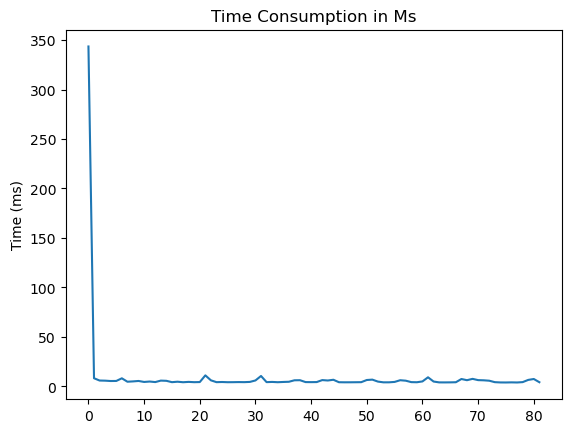

In [136]:
plt.plot(cost_times)
plt.title('Time Consumption in Ms')
plt.ylabel('Time (ms)')

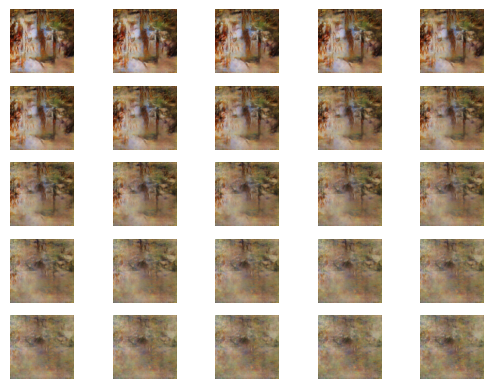

In [150]:
## Preview
n = 5
for i in range(n * n):
	# define subplot
	plt.subplot(n, n, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(generated_images[i])

In [151]:
import imageio
from PIL import Image
import numpy as np

# Specify the path for the output GIF
output_gif_path = './wikiart_artist_animation.gif'

new_width = 512
new_height = 512

with imageio.get_writer(output_gif_path, mode='I', duration=0.05) as writer:
    for image in generated_images:
        # Convert the NumPy array to a PIL Image object
        img = Image.fromarray((image * 255).astype(np.uint8))
        # Resize the image
        img = img.resize((new_width, new_height), Image.NEAREST)
        # Convert the PIL Image back to a NumPy array
        img_resized = np.array(img)
        # Append the resized image to the GIF
        writer.append_data(img_resized)

print("GIF saved at:", output_gif_path)

GIF saved at: ./wikiart_artist_animation.gif
